#### start this notebook on 

- orion partition, 
- normal queue,
- 1 node, 
- 40 tasks, 
- --exclusive for additional slurm parameters
- and don't forget to type your conda env path in the additional kernel locations box

#### conda packages needed

dask, distributed, xarray, rioxarray, rasterio, numpy, pandas, xesmf, netcdf4, glob2, matplotlib, ipykernel


---
# Things from 2024-03-13 meeting
---

# Reproject bounding box

this section runs faster using dask single-machine scheduler (the default) instead of dask distributed (where we would set up a cluster/client)

In [1]:
# packages
import xarray as xr
import rioxarray as rio

In [2]:
# paths
basedir='/our/shared/datasets/dir/'
path_to_raw_data = 'raw_data/'
path_to_climatic = basedir + path_to_raw_data + 'ERA5/month/'

path_to_pre = path_to_climatic + 'era5_monthly_means_50_21_pre.nc'
path_to_atlas_ai=basedir + path_to_raw_data + 'ATLAS-AI project/ATLAS-AI/AWI/2022_AWI_43-SSA-contiguous_AWI_43-SSA_2003.tif'

# btw, I highly recommend replacing the space with an underscore in the dir "ATLAS-AS project"
# spaces in dir and file names can cause problems in a linux operating system

In [3]:
# AWI
atlas_ai=xr.open_dataset(path_to_atlas_ai)
atlas_ai_unproj=atlas_ai.rio.reproject(4326) # reproject the whole thing
minx,miny,maxx,maxy = atlas_ai_unproj.rio.bounds() # now get the bounds
print(minx,miny,maxx,maxy)
atlas_ai_unproj

-25.41333938774126 -37.46356887029586 63.54114216184068 27.363195735869255


<xarray.Dataset> Size: 299MB
Dimensions:      (x: 10124, y: 7378, band: 1)
Coordinates:
  * x            (x) float64 81kB -25.41 -25.4 -25.39 ... 63.52 63.53 63.54
  * y            (y) float64 59kB 27.36 27.35 27.34 ... -37.44 -37.45 -37.46
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Data variables:
    band_data    (band, y, x) float32 299MB nan nan nan nan ... nan nan nan nan

#### notice the longitude coordinates in atlas_ai_unproj are on the -180 to 180 scale not 0 to 360 scale

#### if we plot the original data atlas_ai and the reprojected data atlas_ai_unproject we can see the reprojection worked

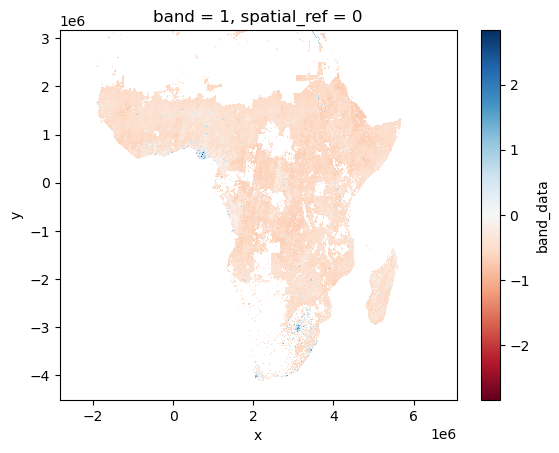

In [41]:
# plot
atlas_ai.band_data.plot(cmap='RdBu')

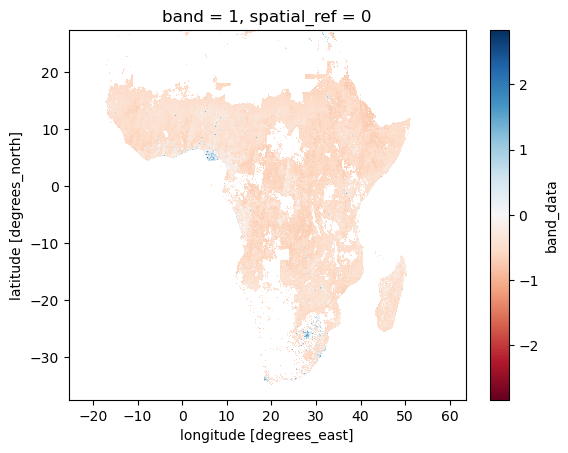

In [42]:
# plot
atlas_ai_unproj.band_data.plot(cmap='RdBu')


In [4]:
del atlas_ai, atlas_ai_unproj # free up RAM

#### it looks like part of the top of Africa is chopped off even in the original AWI data file, so the reprojection has the same extents

#### now look at precipitation

In [5]:
# let it auto chunk
pre_world = xr.open_dataarray(path_to_pre, decode_coords = "all", chunks='auto')#{'time':-1,'latitude':-1,'longitude':60})
pre_world

<xarray.DataArray 'tp' (time: 864, latitude: 1801, longitude: 3600)> Size: 22GB
dask.array<open_dataset-tp, shape=(864, 1801, 3600), dtype=float32, chunksize=(156, 327, 655), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 14kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
  * latitude   (latitude) float32 7kB 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2021-12-01
Attributes:
    units:      m
    long_name:  Total precipitation

#### pre_world longitudes are 0 to 360. this is what was causing the problem clipping part of Africa incorrectly

#### to fix the problem, just re-write the longitude coordinate to -180 to 180

#### this is something that should be done for every input dataset as part of the data cleaning process anyways

In [6]:
lon_attrs=pre_world.longitude.attrs # copy metadata
pre_world.coords['longitude']=xr.where(pre_world.coords['longitude']>180,pre_world.coords['longitude']-360,pre_world.coords['longitude'])
pre_world=pre_world.roll(longitude=1799,roll_coords=True)
pre_world['longitude'].attrs=lon_attrs
pre_world.rio.write_crs(4326, inplace = True)
pre_world

<xarray.DataArray 'tp' (time: 864, latitude: 1801, longitude: 3600)> Size: 22GB
dask.array<rechunk-merge, shape=(864, 1801, 3600), dtype=float32, chunksize=(156, 327, 655), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float32 7kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
  * time         (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2021-12-01
  * longitude    (longitude) float32 14kB -179.9 -179.8 -179.7 ... 179.9 180.0
    spatial_ref  int64 8B 0
Attributes:
    units:      m
    long_name:  Total precipitation

In [7]:
%%time
# this will crash your notebook if you aren't running on enough cores for this ~21GB data variable
# the fewer tasks you've launched the jupyter session with, the slower this will run
pre_world=pre_world.compute()

CPU times: user 41.3 s, sys: 1min 41s, total: 2min 22s
Wall time: 1min 39s


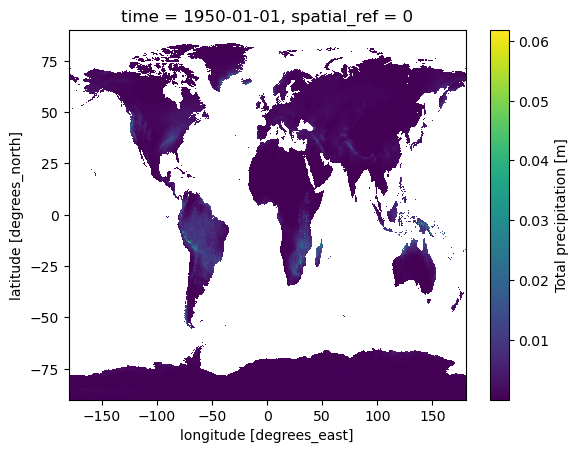

In [8]:
pre_world.isel(time=0).plot()

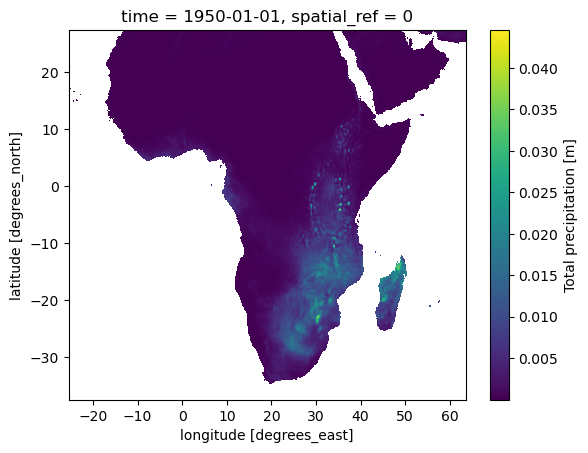

In [9]:
pre = pre_world.rio.clip_box(minx,miny,maxx,maxy)
pre.isel(time=0).plot()

#### since the atlas_ai variable doesn't include the northernmost part of Africa this clip looks like it worked correctly

---
### rewrite netcdf files to change dimension/coordinate names

In [ ]:
import xarray as xr

In [14]:
# use dask distributed, starting a LocalCluster
# we are using dask.distributed LocalCluster because I couldn't get this to work with regular dask 
# (default is the single-machine scheduler where you don't have to start a LocalCluster)

# if you started the notebook on 1 node, 40 tasks, you will have 80 threads to work with
# the notebook itself is also running on 1 (or likely more than 1) of these threads
# usually when I start a local cluster I'll start it on a few less than 80 to try to avoid crashing the notebook
# Full disclosure, I'm not 100% sure this technique of using slightly less threads does what I think

from dask.distributed import Client,LocalCluster

nworkers=72 # I'm choosing a few less than 80  
cluster=LocalCluster(n_workers=nworkers,threads_per_worker=1) # a cluster where each thread is a separate process or "worker"
client=Client(cluster)  # connect to your compute cluster
client.wait_for_workers(n_workers=nworkers,timeout=10) # wait up to 10s for the cluster to be fully ready, error if not ready in 10s
client # print info

In [11]:
# something weird is going on with the ERA5 file when time gets decoded
# so first, don't decode time
ds=xr.open_dataset(path_to_pre,chunks='auto',decode_times=False,lock=False).rename({'latitude':'lat','longitude':'lon'})

# then, copy the attributes from the un-decoded time variable
# we'll use these later when we re-write the netcdf
calendar=ds.time.attrs['calendar']
units=ds.time.attrs['units']

# then, decode time with the cftime library
ds=xr.decode_cf(ds,use_cftime=True)
ds=ds.transpose('lat','lon','time') # reorder dimensions

# change precip units
ds['tp']=ds.tp*1000. # m-->mm
ds.tp.attrs['units']='mm'
ds

<xarray.Dataset> Size: 22GB
Dimensions:  (lon: 3600, lat: 1801, time: 864)
Coordinates:
  * lon      (lon) float32 14kB 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
  * lat      (lat) float32 7kB 90.0 89.9 89.8 89.7 ... -89.7 -89.8 -89.9 -90.0
  * time     (time) object 7kB 1950-01-01 00:00:00 ... 2021-12-01 00:00:00
Data variables:
    tp       (lat, lon, time) float32 22GB dask.array<chunksize=(327, 655, 156), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-03-20 10:29:43 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [12]:
# new file path and name
outdir=basedir+'temporary/'
prfile=outdir+'era5_monthly_means_50_21_pre.nc'

In [13]:
%%time

# the encodings below allow you to keep the same dimension/coordinate attributes from the original file
# we are essentially overriding some xarray default settings here
time_encoding={'_FillValue':None,'calendar':calendar,'units':units} 
lat_encoding={'_FillValue':None}
lon_encoding={'_FillValue':None}

# compute and write new file in parallel
output=ds.to_netcdf(prfile,
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding},
            compute=False)
output.compute()

CPU times: user 1min 7s, sys: 26.2 s, total: 1min 33s
Wall time: 3min 1s


In [54]:
client.shutdown()

---
### run climate-indices command line tool

This section probably doesn't run, but I'm leaving it in here as example code. 

It would only work if you've installed the climate-indices package with pip (last step after building your conda env) and you're working with a self installed version of miniconda instead of the system module miniconda.

In [ ]:
import subprocess
import matplotlib.pyplot as plt

In [ ]:
# below works for me but probably won't for others
# this is because I'm using my own installation of miniconda instead of using the Orion system module conda
# we'll probably have to go through it together and modify a few things to get it working 

# user conda information
user_home='$HOME/'
conda_init_file=user_home+'miniconda3/etc/profile.d/conda.sh'  # you need to find your conda.sh script
conda_env='/workspace/username/envs/dataprep' # path user-specific conda env

# create command enclosed in ""
# everything but the final command should end with ;
command_conda_init=". "+conda_init_file+";"               # initialize conda
command_env_activate="conda activate "+conda_env+";"      # activate conda environment 
command_echo_env="echo 'conda env =' $CONDA_DEFAULT_ENV;" # print active env name
command_spi="process_climate_indices "+\
                "--index spi "+\
                "--periodicity monthly "+\
                "--netcdf_precip "+prfile+" "\
                "--var_name_precip tp "+\
                "--output_file_base "+outdir+" "\
                "--scales 6 12 "+\
                "--calibration_start_year 1951 "+\
                "--calibration_end_year 2021 "+\
                "--multiprocessing all"

In [ ]:
# double check spaces are all good in command_spi
command_spi

In [ ]:
# string all the commands together
# climate-indices commands take a very long time, this took 30 minutes to run
# also you get a lot of divide by zero and nan runtime warning and unless 
# the climate-indices source is modified, I don't think there is any way to silence 
# these when calling from python like this

subprocess.run(command_conda_init+
               command_env_activate+
               command_echo_env+
               command_spi,
               shell=True)

In [ ]:
# take a look at the results
ds_g06=xr.open_dataset(basedir+'temporary/_spi_gamma_06.nc')
ds_g12=xr.open_dataset(basedir+'temporary/_spi_gamma_12.nc')
ds_p06=xr.open_dataset(basedir+'temporary/_spi_pearson_06.nc')
ds_p12=xr.open_dataset(basedir+'temporary/_spi_pearson_12.nc')
ds_g06

In [ ]:
# 6-month spi so first 5 time indexes will be nan
# import cartopy
fig=plt.figure(figsize=(15,10))

ax=fig.add_subplot(221)
ds_g06.spi_gamma_06.isel(time=11).plot(ax=ax)

ax=fig.add_subplot(222)
ds_g12.spi_gamma_12.isel(time=11).plot(ax=ax)


ax=fig.add_subplot(223)
ds_p06.spi_pearson_06.isel(time=11).plot(ax=ax)

ax=fig.add_subplot(224)
ds_p12.spi_pearson_12.isel(time=11).plot(ax=ax)

In [ ]:
fig=plt.figure(figsize=(15,2))
y1=ds_g06.spi_gamma_06.sel(lat=0,lon=25,method='nearest')  # gamma in blue
y2=ds_p06.spi_pearson_06.sel(lat=0,lon=25,method='nearest') # pearson in orange
y1.plot()
y2.plot()
plt.axhline(y=0,color='grey',linestyle='--')
plt.show()


fig=plt.figure(figsize=(15,2))
y1=ds_g12.spi_gamma_12.sel(lat=0,lon=25,method='nearest')  # gamma in blue
y2=ds_p12.spi_pearson_12.sel(lat=0,lon=25,method='nearest') # pearson in orange
y1.plot()
y2.plot()
plt.axhline(y=0,color='grey',linestyle='--')
plt.show()

---
# Things from 2024-03-20 meeting
---
- aggregate tif data to netcdf with time dim

In [ ]:
# general workflow

# 1) fix up metadata before writing to netcdf
# atlas_ai=atlas_ai.squeeze()
# del atlas_ai.coords['band']
# atlas_ai=atlas_ai.rename({'band_data':'AWI'})

# 2) create time dim

# 3) create netcdf encodings

# 4) write netcdf

In [ ]:
# how to open multiple files at once
# xr.open_mfdataset()

---
# Things from 2024-03-27 meeting
---

### xesmf area conservative regridding and comparing to rasterio sum, bilinear

Here I use some different methods than what is in prepare_data.ipynb to get filenames, years, and I/O of data. It may not be any better or faster than your prepare_data.ipynb code, I just want to show you some other options.

I'm regridding from the pop grid to the ERA5 grid as you were doing in prepare_data.ipynb. But as we talked about, I think you should probably make the population grid your common grid and regrid all your other data to it. This way you don't have to worry about how regridding affects your population variable and any other variables that are computed with it. Bilinear "upsampling" of climate data (going from coarser to finer resolution) is standard practice and shouldn't cause problems in a peer-review.

In [1]:
import glob
import numpy as np
import xarray as xr
import rioxarray as rio
import pandas as pd
import xesmf as xe
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
import matplotlib

In [37]:
# I'm going chunk the datasets and use dask to speed up the computing
# so start a local cluster

from dask.distributed import Client,LocalCluster

nworkers=40   
cluster=LocalCluster(n_workers=nworkers,threads_per_worker=1) # a cluster where each thread is a separate process or "worker"
client=Client(cluster)  # connect to your compute cluster
client.wait_for_workers(n_workers=nworkers,timeout=10) # wait up to 10s for the cluster to be fully ready, error if not ready in 10s
client # print info

In [13]:
basedir='/path/to/our/shared/datasets/dir/'
path_to_raw_data = basedir+'raw_data/'
path_to_processed_data = basedir+'processed_data/'

path_to_wealth = path_to_raw_data + 'ATLAS/wealth/'
path_to_pop = path_to_raw_data + 'ATLAS/population/'

# 'auto' for chunksize produces 4 chunks per pop/wealth data file
# {'x':500,'y':-1} for chunksize produces 20 chunks per pop/wealth data file
# {'x':500,'y':-1} turns out to go a few seconds faster than 'auto' for each .compute()
chunksize={'x':500,'y':-1} # 'auto'

In [4]:
# a list of all wealth and all pop files, sorted by year ascending
wealth_files=sorted(glob.glob(path_to_wealth + '*.tif'))
pop_files = sorted(glob.glob(path_to_pop + '*POP_43-SSA_*.tif'))

# create list of years from file names
years_wealth=[f[-8:-4] for f in wealth_files] # this is a python list comprehension
years_pop=[f[-8:-4] for f in pop_files]

# check there are the same number of files and same years in the wealth and pop file names
assert len(wealth_files)==len(pop_files), f'found {len(wealth_files)} wealth files, {len(pop_files)} pop files'
assert years_wealth==years_pop, f'found different years of wealth and pop files'

In [5]:
# create datetimes
dates=pd.date_range(years_wealth[0],years_wealth[-1],freq='YS')
dates

DatetimeIndex(['2003-01-01', '2004-01-01', '2005-01-01', '2006-01-01',
               '2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01',
               '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01',
               '2019-01-01', '2020-01-01', '2021-01-01'],
              dtype='datetime64[ns]', freq='YS-JAN')

In [14]:
# do the minimum amount of processing to get all data years into an xr.dataArray
wealth_list=[]
for iy,f in enumerate(wealth_files):
    # xarray instead of rio will do the nan replacement for you
    # squeeze out the singleton dim 'band' when reading
    # the data variable will be automatically named 'band_data' in the dataset
    # here I'm putting each file into a dask array with a single chunk
    # chunking signals to hold nothing in memory and to make computations lazy until we call compute
    
    data=xr.open_dataset(f).squeeze().chunk(chunksize)
    wealth_list.append(data)
    
# now we have a list of datasets in the correct time order, nothing held in memory
# look at one array in the list
wealth_list[0]

<xarray.Dataset> Size: 304MB
Dimensions:      (x: 9902, y: 7673)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 79kB -2.828e+06 -2.828e+06 ... 7.072e+06 7.072e+06
  * y            (y) float64 61kB 3.168e+06 3.167e+06 ... -4.503e+06 -4.504e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float32 304MB dask.array<chunksize=(7673, 500), meta=np.ndarray>

In [15]:
%%time
# concatenate list of arrays on a new time dimension
wealth_ds=xr.concat(wealth_list,dim='time')
wealth_ds=wealth_ds.compute()
wealth_ds

CPU times: user 4.41 s, sys: 6.25 s, total: 10.7 s
Wall time: 9.79 s


<xarray.Dataset> Size: 6GB
Dimensions:      (x: 9902, y: 7673, time: 19)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 79kB -2.828e+06 -2.828e+06 ... 7.072e+06 7.072e+06
  * y            (y) float64 61kB 3.168e+06 3.167e+06 ... -4.503e+06 -4.504e+06
    spatial_ref  int64 8B 0
Dimensions without coordinates: time
Data variables:
    band_data    (time, y, x) float32 6GB nan nan nan nan ... nan nan nan nan

In [18]:
# add time coordinate info and clean up other metadata
wealth_ds=wealth_ds.assign_coords({'time':dates})
del wealth_ds.coords['band']
wealth_ds=wealth_ds.rename({'band_data':'wealth_pc'})
wealth_ds

<xarray.Dataset> Size: 6GB
Dimensions:      (x: 9902, y: 7673, time: 19)
Coordinates:
  * x            (x) float64 79kB -2.828e+06 -2.828e+06 ... 7.072e+06 7.072e+06
  * y            (y) float64 61kB 3.168e+06 3.167e+06 ... -4.503e+06 -4.504e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 152B 2003-01-01 2004-01-01 ... 2021-01-01
Data variables:
    wealth_pc    (time, y, x) float32 6GB nan nan nan nan ... nan nan nan nan

In [22]:
%%time
# do the same for population
pop_list=[]
for iy,f in enumerate(pop_files):
    pop_list.append(xr.open_dataset(f).squeeze().chunk(chunksize))    

pop_ds=xr.concat(pop_list,dim='time')
pop_ds=pop_ds.compute()

pop_ds=pop_ds.assign_coords({'time':dates})
del pop_ds.coords['band']
pop_ds=pop_ds.rename({'band_data':'pop'})
pop_ds  

CPU times: user 4.11 s, sys: 5.66 s, total: 9.78 s
Wall time: 8.96 s


<xarray.Dataset> Size: 6GB
Dimensions:      (x: 9902, y: 7673, time: 19)
Coordinates:
  * x            (x) float64 79kB -2.828e+06 -2.828e+06 ... 7.072e+06 7.072e+06
  * y            (y) float64 61kB 3.168e+06 3.167e+06 ... -4.503e+06 -4.504e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 152B 2003-01-01 2004-01-01 ... 2021-01-01
Data variables:
    pop          (time, y, x) float32 6GB nan nan nan nan ... nan nan nan nan

In [23]:
# check metadata is the same in both datasets
assert all(wealth_ds.x==pop_ds.x), f'pop and wealth have different longitudes'
assert all(wealth_ds.y==pop_ds.y), f'pop and wealth have different latitudes'
assert wealth_ds.spatial_ref.attrs==pop_ds.spatial_ref.attrs, f'pop and wealth have different spatial references'
assert wealth_ds.wealth_pc.attrs==pop_ds.pop.attrs, f'pop and wealth have different attributes'
assert wealth_ds.wealth_pc.dtype==pop_ds.pop.dtype, f'pop has dtype {pop_ds.pop.dtype}, wealth has dtype {wealth_ds.wealth_pc.dtype}'

In [24]:
# no errors, we're safe to combine variables into one dataset
ds=wealth_ds.copy()
ds['pop']=pop_ds.pop
ds['wealth']=ds.pop*ds.wealth_pc

print(ds.rio.crs)
ds

EPSG:3857


<xarray.Dataset> Size: 17GB
Dimensions:      (x: 9902, y: 7673, time: 19)
Coordinates:
  * x            (x) float64 79kB -2.828e+06 -2.828e+06 ... 7.072e+06 7.072e+06
  * y            (y) float64 61kB 3.168e+06 3.167e+06 ... -4.503e+06 -4.504e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 152B 2003-01-01 2004-01-01 ... 2021-01-01
Data variables:
    wealth_pc    (time, y, x) float32 6GB nan nan nan nan ... nan nan nan nan
    pop          (time, y, x) float32 6GB nan nan nan nan ... nan nan nan nan
    wealth       (time, y, x) float32 6GB nan nan nan nan ... nan nan nan nan

In [25]:
%%time

# reproject the whole thing
pop_3857=ds.pop
pop_4326=pop_3857.rio.reproject('EPSG:4326')

# now subset to a test area
# define tiny area in North Africa
# the lat/lons of the area we want after regridding
latN_NA,latS_NA=19.75,19.5
lonW_NA,lonE_NA=29.0,29.25
# the lat/lons of the area to use for regridding 
# (which includes a buffer based on the target grid resolution)
buff=0.1
latN_NA_clip,latS_NA_clip=latN_NA+buff,latS_NA-buff
lonW_NA_clip,lonE_NA_clip=lonW_NA-buff,lonE_NA+buff

# subset
# contains the area we want to regrid plus a buffer so we don't get nan on regridded edge pixels
pop_4326_NA=pop_4326.sel(y=slice(latN_NA_clip,latS_NA_clip),x=slice(lonW_NA_clip,lonE_NA_clip))
pop_4326_NA.rio.write_crs(4326, inplace = True)
print(pop_4326_NA.shape)

# 4326 bounds on the pop grid (includes buffer)
minx,miny,maxx,maxy = pop_4326_NA.rio.bounds()
print(minx,miny,maxx,maxy)

(19, 51, 52)
28.895989973970117 19.402630713751392 29.352887745658997 19.850741989830873
CPU times: user 26.6 s, sys: 4.93 s, total: 31.6 s
Wall time: 23.1 s


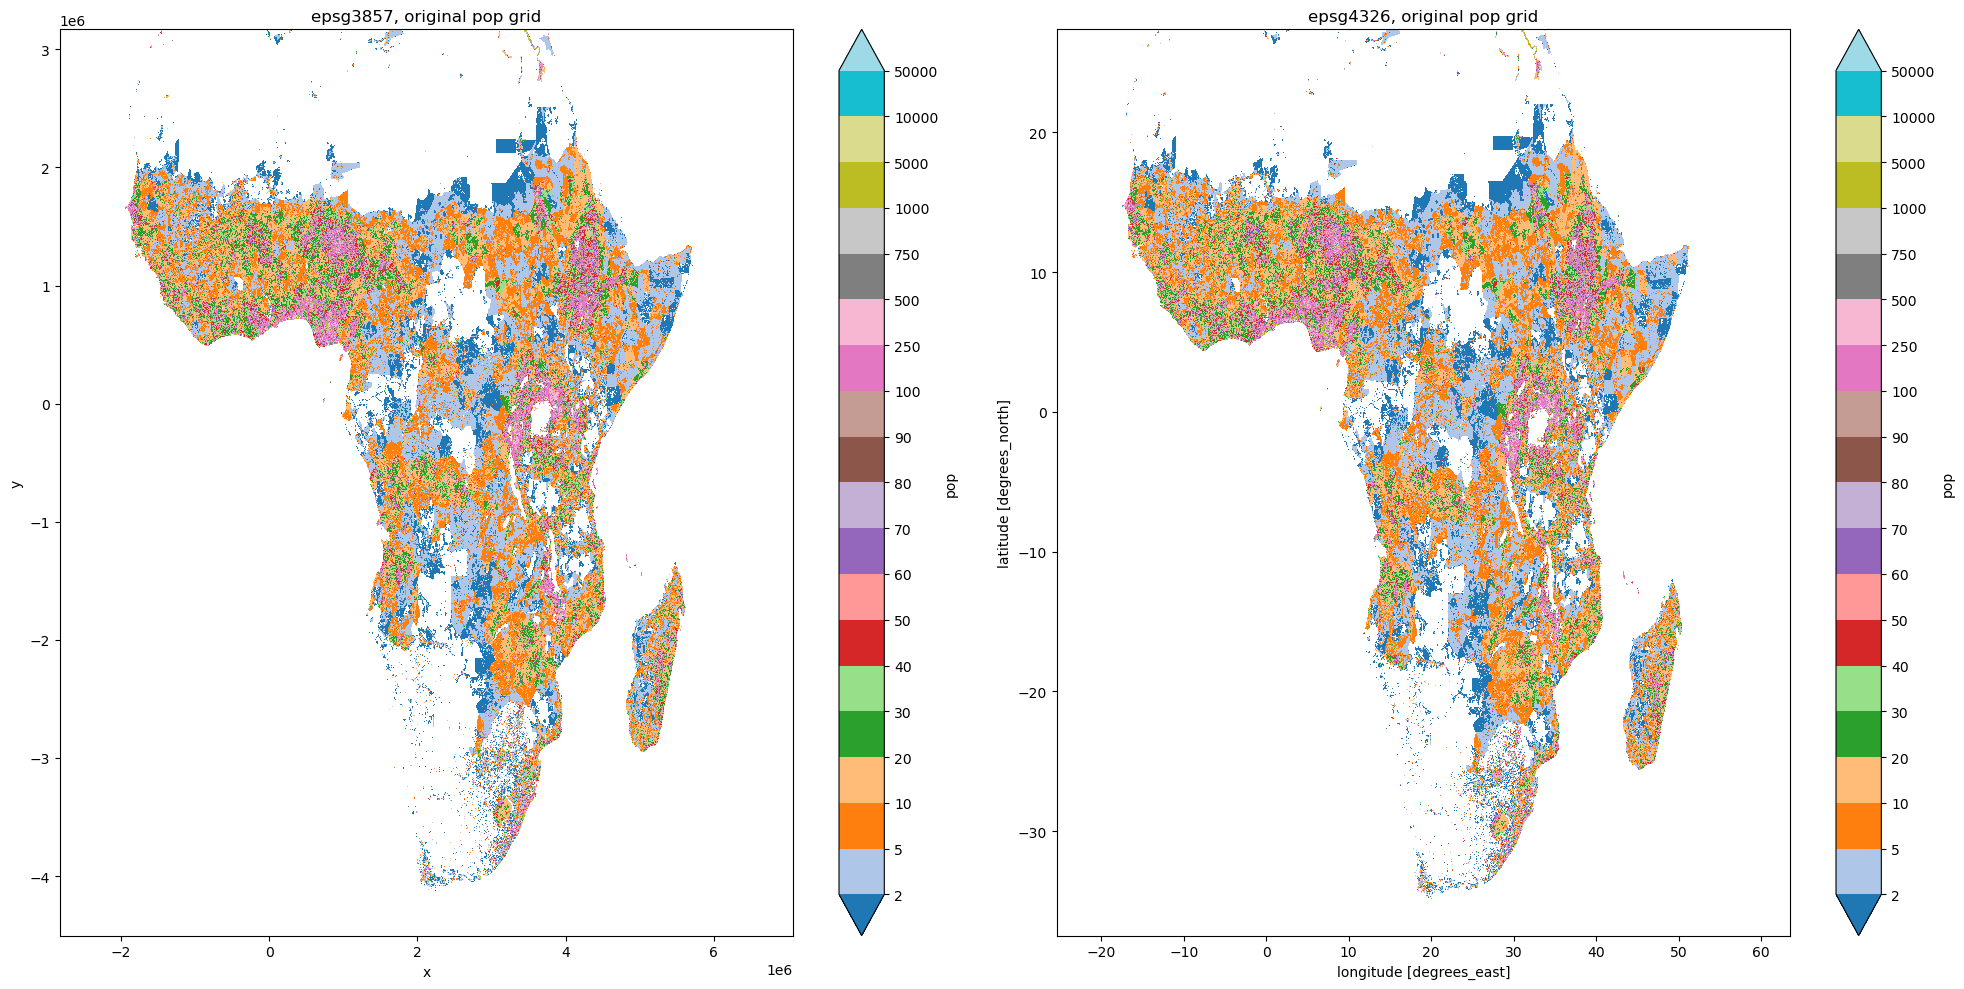

In [26]:
# plot all of Africa projection 3857 vs 4326
levels=[2,5,10,20,30,40,50,60,70,80,90,100,250,500,750,1000,5000,10000,50000]
cmap='tab20'
cbar_kwargs={'ticks':levels}

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(121) 
pop_3857.isel(time=0).plot(ax = ax, levels=levels,cmap=cmap,cbar_kwargs=cbar_kwargs)
plt.title('epsg3857, original pop grid')

ax = fig.add_subplot(122) 
pop_4326.isel(time=0).plot(ax = ax, levels=levels,cmap=cmap,cbar_kwargs=cbar_kwargs)
plt.title('epsg4326, original pop grid')

plt.tight_layout()
plt.show()

### look at regridding methods over a tiny area in North Africa

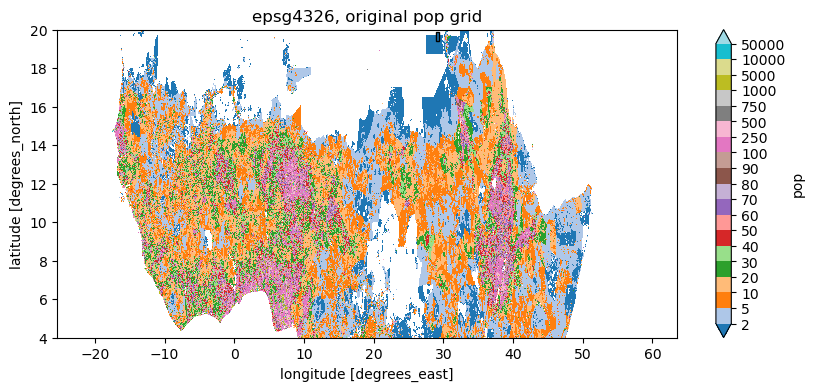

In [27]:
# show the tiny area on a larger map (it's at the top on the blue square of data)

fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(111)

# plot same 4326 pop data as above, subset in latitude
pop_4326.sel(time='2003',y=slice(20,4)).plot(ax = ax, levels=levels,cmap=cmap,cbar_kwargs=cbar_kwargs)
plt.title('epsg4326, original pop grid')

# add a black rectangle based on the clip coordinates
rect = plt.Rectangle(xy=(lonW_NA_clip,latS_NA_clip), 
                     width=(lonE_NA_clip-lonW_NA_clip), 
                     height=(latN_NA_clip-latS_NA_clip),
                     facecolor=None,
                     edgecolor="black")
ax.add_patch(rect)

plt.show()

In [28]:
# target grid for tiny North Africa
path_to_pre = path_to_raw_data + 'ERA5/month/era5_monthly_means_50_21_pre.nc'
pre = rio.open_rasterio(path_to_pre).sel(time='2003-01-01').squeeze() # getting a single time
del pre.coords['time']
pre = pre.assign_coords(x = (((pre.x + 180) % 360) - 180)).sortby('x') # fix longitudes
pre.rio.write_crs(4326, inplace = True) # add crs info
target_grid = pre.rio.clip_box(lonW_NA,latS_NA,lonE_NA,latN_NA) # target grid boundaries fully inside of clipped area

# 3857 bounds of target grid (fully inside of clipped area)
minx_3857,miny_3857,maxx_3857,maxy_3857 = target_grid.rio.reproject('EPSG:3857').rio.bounds() 
print(minx_3857,miny_3857,maxx_3857,maxy_3857)

# the data in target_grid doesn't matter
# xesmf will only use its coordinate and crs info for regridding population
target_grid

3222699.2038117703 2209344.583118479 3268624.4289269354 2255269.808233644


<xarray.DataArray 'tp' (y: 4, x: 4)> Size: 32B
array([[-32766, -32766, -32766, -32766],
       [-32766, -32766, -32766, -32766],
       [-32766, -32766, -32766, -32766],
       [-32766, -32766, -32766, -32766]], dtype=int16)
Coordinates:
  * y            (y) float64 32B 19.8 19.7 19.6 19.5
  * x            (x) float64 32B 29.0 29.1 29.2 29.3
    spatial_ref  int64 8B 0
Attributes: (12/14)
    latitude#long_name:      latitude
    latitude#units:          degrees_north
    longitude#long_name:     longitude
    longitude#units:         degrees_east
    Conventions:             CF-1.6
    history:                 2023-03-20 10:29:43 GMT by grib_to_netcdf-2.24.0...
    ...                      ...
    NETCDF_DIM_time_VALUES:  [ 438288.  439032.  439704.  440448.  441168.  4...
    add_offset:              0.09056213144691026
    long_name:               Total precipitation
    scale_factor:            2.763892052586199e-06
    units:                   ('m', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm...
    _FillValue:              -32767

In [29]:
# data to regrid
data_in=pop_4326_NA.sel(time='2003') # apparently it's a known issue that rioxarray drops the crs often
data_in.rio.write_crs("epsg:4326", inplace = True) # so re-write it
data_in.y.attrs={'standard_name':'latitude'} # dim names x,y with no associated label 'latitude','longitude' can cause problems
data_in.x.attrs={'standard_name':'longitude'} # so add this metadata
print(data_in.shape, target_grid.shape)
print(data_in.rio.crs)
data_in

(1, 51, 52) (4, 4)
EPSG:4326


<xarray.DataArray 'pop' (time: 1, y: 51, x: 52)> Size: 11kB
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [1.2013805, 1.199194 , 1.2003181, ..., 1.1709324, 1.171946 ,
         1.1741686],
        [1.2031254, 1.2013125, 1.1985093, ..., 1.1697217, 1.1708883,
         1.1803136],
        [1.199977 , 1.1986145, 1.197251 , ..., 1.168297 , 1.173292 ,
         1.1756209]]], dtype=float32)
Coordinates:
  * x            (x) float64 416B 28.9 28.91 28.92 28.93 ... 29.33 29.34 29.35
  * y            (y) float64 408B 19.85 19.84 19.83 19.82 ... 19.42 19.42 19.41
  * time         (time) datetime64[ns] 8B 2003-01-01
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area

In [30]:
# rioxarray regrid
# rio bilinear
pop_4326_rio_bilinear = data_in.rio.reproject_match(target_grid, resampling = Resampling.bilinear)
# rio sum
pop_4326_rio_sum = data_in.rio.reproject_match(target_grid, resampling = Resampling.sum)

In [31]:
# xesmf regrid
# set up the regridder functions
regridder_bilinear=xe.Regridder(data_in,target_grid,'bilinear',unmapped_to_nan=True) # calc weights
regridder_conservative=xe.Regridder(data_in,target_grid,'conservative',unmapped_to_nan=True) # calc weights
print(regridder_bilinear)
print('----------------------------------------')
print(regridder_conservative)

# execute the regridding
print('executing bilinear regrid...')
result_bilinear=regridder_bilinear(data_in,skipna=True,na_thres=1.) # apply weights
print('executing conservative regrid...')
result_conservative=regridder_conservative(data_in,skipna=True,na_thres=1.) # apply weights

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_51x52_4x4.nc 
Reuse pre-computed weights? False 
Input grid shape:           (51, 52) 
Output grid shape:          (4, 4) 
Periodic in longitude?      False
----------------------------------------
xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_51x52_4x4.nc 
Reuse pre-computed weights? False 
Input grid shape:           (51, 52) 
Output grid shape:          (4, 4) 
Periodic in longitude?      False
executing bilinear regrid...


/work/hpc/users/kerrie/envs/prep_xesmf/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


executing conservative regrid...


/work/hpc/users/kerrie/envs/prep_xesmf/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


#### idk what that warning is about, it's a new one for me

In [32]:
# put all these things in a single dataset (just for fun)
results_ds=result_bilinear.to_dataset(name='pop_4326_xe_bilinear')
results_ds['pop_4326_xe_conservative']=result_conservative
results_ds['pop_4326_rio_bilinear']=pop_4326_rio_bilinear
results_ds['pop_4326_rio_sum']=pop_4326_rio_sum
results_ds

<xarray.Dataset> Size: 464B
Dimensions:                   (time: 1, y: 4, x: 4)
Coordinates:
  * time                      (time) datetime64[ns] 8B 2003-01-01
    spatial_ref               int64 8B 0
  * y                         (y) float64 32B 19.8 19.7 19.6 19.5
  * x                         (x) float64 32B 29.0 29.1 29.2 29.3
Data variables:
    pop_4326_xe_bilinear      (time, y, x) float64 128B nan nan ... 1.185 1.204
    pop_4326_xe_conservative  (time, y, x) float64 128B nan nan ... 1.188 1.201
    pop_4326_rio_bilinear     (time, y, x) float32 64B nan nan nan ... 1.19 1.2
    pop_4326_rio_sum          (time, y, x) float32 64B nan nan ... 153.9 155.6

In [33]:
# print the data ranges for the original data and each regrid method

# remember, the original 3857 data is clipped to a slightly larger area than our regridded data
print('pop_3857',
      pop_3857.rio.clip_box(minx_3857,miny_3857,maxx_3857,maxy_3857).min().data,
      pop_3857.rio.clip_box(minx_3857,miny_3857,maxx_3857,maxy_3857).max().data)

# print min/max for each variable in the dataset
for var in results_ds.keys():
    print(var, results_ds[var].min().data,results_ds[var].max().data)

pop_3857 1.0009828805923462 1.5244393348693848
pop_4326_xe_bilinear 1.1796698570251465 1.2045862674713135
pop_4326_xe_conservative 1.1720768733377265 1.2010134458541568
pop_4326_rio_bilinear 1.1735433340072632 1.1996543407440186
pop_4326_rio_sum 92.31649017333984 155.56668090820312


#### in the next plot we want to force all our colorbars to have the exact same discrete values and colors, so we get the color names from the colormap in hex format, this way we can specific which color should go with which data values

In [34]:
cmap = matplotlib.colormaps['tab20']
hexcolors=[matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]
hexcolors

['#1f77b4',
 '#aec7e8',
 '#ff7f0e',
 '#ffbb78',
 '#2ca02c',
 '#98df8a',
 '#d62728',
 '#ff9896',
 '#9467bd',
 '#c5b0d5',
 '#8c564b',
 '#c49c94',
 '#e377c2',
 '#f7b6d2',
 '#7f7f7f',
 '#c7c7c7',
 '#bcbd22',
 '#dbdb8d',
 '#17becf',
 '#9edae5']

plotting...
6 7


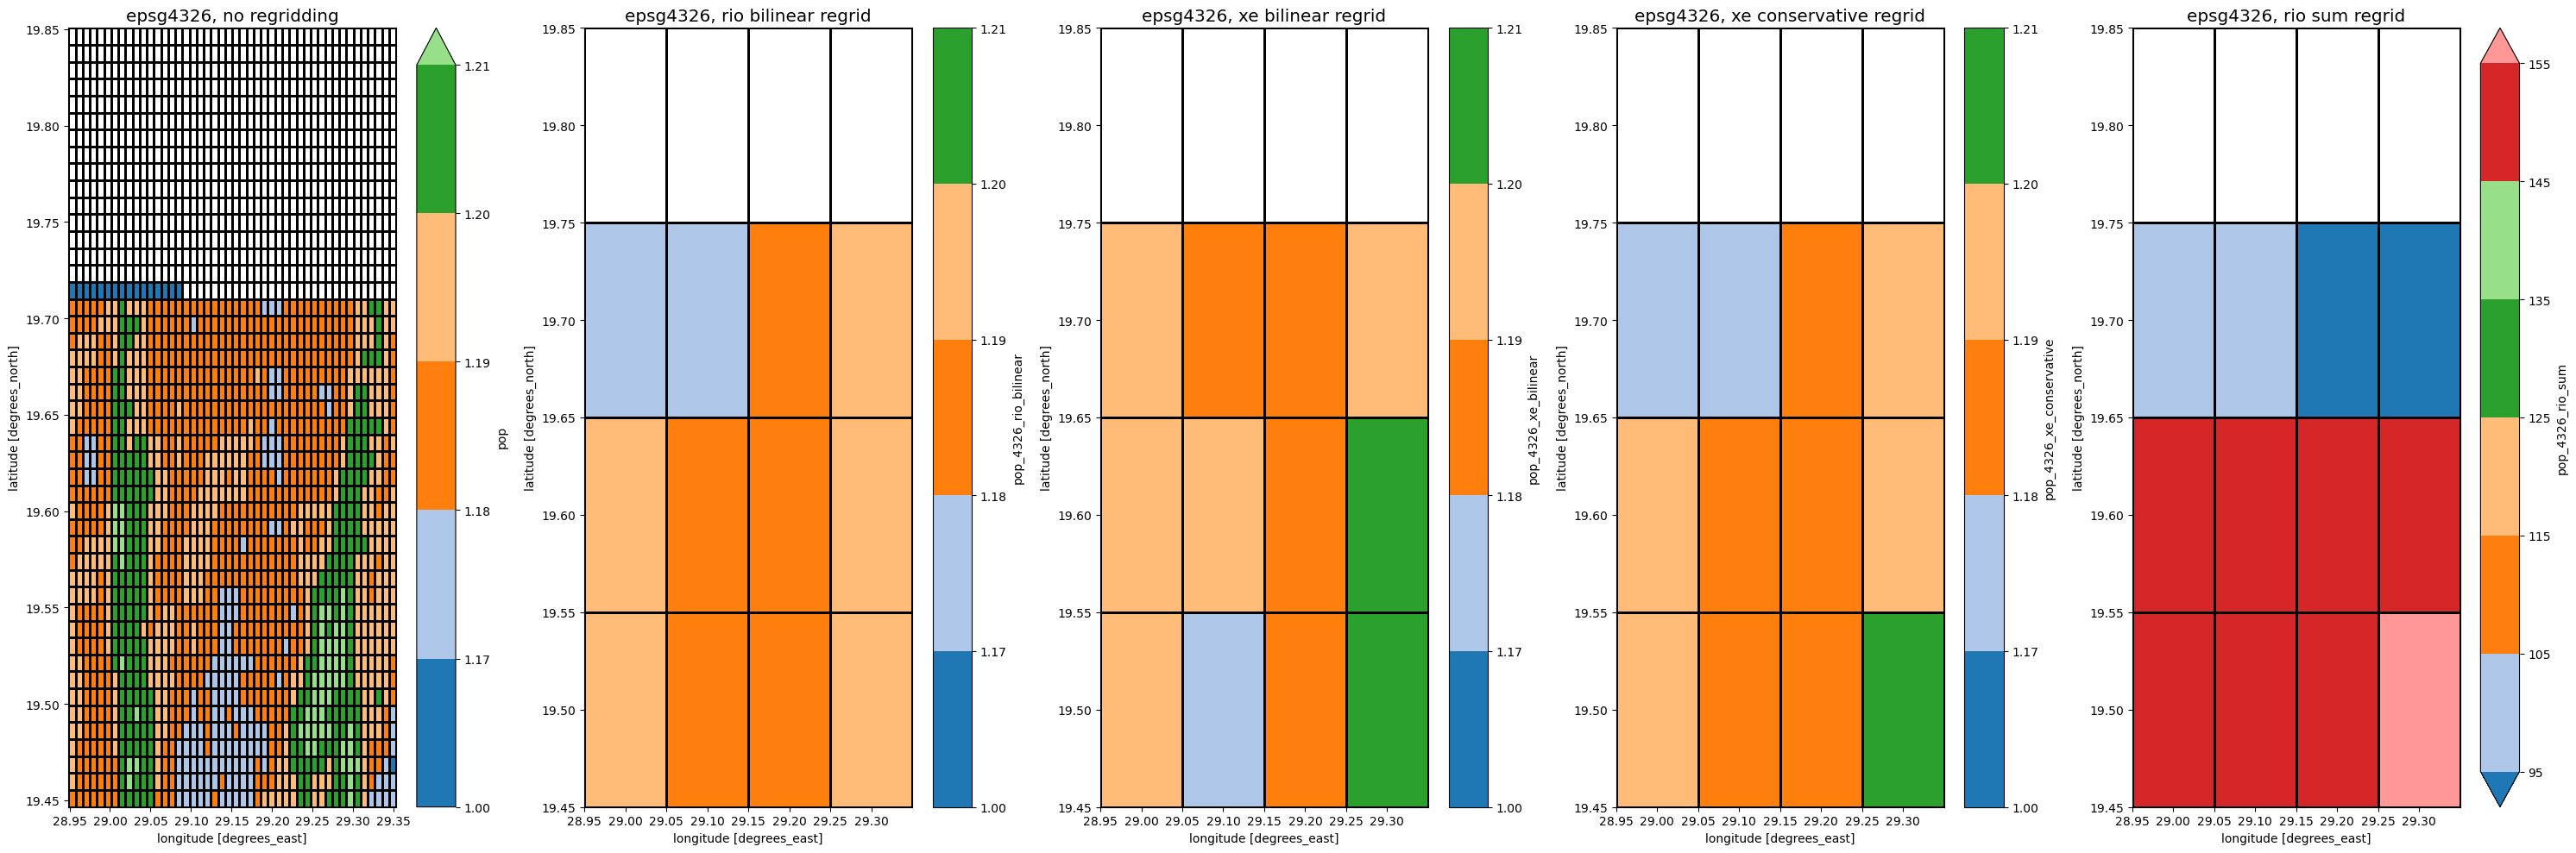

In [35]:
# obviously you would want Resampling.sum if regridding population from 
# fine to coarse resolution (which you should probably avoid doing anyway)
# but here is a picture of what all the regrid methods are doing
# edgecolor is what turns on the pixel boundaries

# plot
print('plotting...')
levels=[1,1.17,1.18,1.19,1.20,1.21] # custom levels for colorbar
colors=hexcolors[:len(levels)+1] # custom colors for colorbar
print(len(levels),len(colors)) # should be 1 more color than level

# figure with 5 subplots
fig = plt.figure(figsize = (30, 10))
ax = fig.add_subplot(151) 
cbar_kwargs={'ticks':levels,'extend':'max'} # I'm setting the extend part based on the min/max of each variable
pop_4326_NA.sel(time='2003',x=slice(28.95,29.35),y=slice(19.85,19.45)).plot(ax=ax,levels=levels,colors=colors,cbar_kwargs=cbar_kwargs,edgecolor='black')
plt.title('epsg4326, no regridding',fontsize='x-large')

ax = fig.add_subplot(152)
cbar_kwargs={'ticks':levels,'extend':'neither'} # I'm setting the extend part based on the min/max of each variable
results_ds.pop_4326_rio_bilinear.plot(ax = ax, levels=levels,colors=colors,cbar_kwargs=cbar_kwargs,edgecolor='black')
plt.title('epsg4326, rio bilinear regrid',fontsize='x-large')

ax = fig.add_subplot(153)
results_ds.pop_4326_xe_bilinear.plot(ax = ax, levels=levels,colors=colors,cbar_kwargs=cbar_kwargs,edgecolor='black')
plt.title('epsg4326, xe bilinear regrid',fontsize='x-large')

ax = fig.add_subplot(154) 
results_ds.pop_4326_xe_conservative.plot(ax = ax, levels=levels,colors=colors,cbar_kwargs=cbar_kwargs,edgecolor='black')
plt.title('epsg4326, xe conservative regrid',fontsize='x-large')

ax = fig.add_subplot(155)
# different levels and colors for this one
levels=[95,105,115,125,135,145,155]
colors=hexcolors[:len(levels)+1]
cbar_kwargs={'ticks':levels,'extend':'both'} # I'm setting the extend part based on the min/max of each variable
results_ds.pop_4326_rio_sum.plot(ax = ax, levels=levels,colors=colors,cbar_kwargs=cbar_kwargs,edgecolor='black')
plt.title('epsg4326, rio sum regrid',fontsize='x-large')

plt.tight_layout()
plt.show()

In [36]:
client.shutdown()

---